# Heat in Place Montecarlo Simulation for Santiago Papasquiaro

Monte Carlo simulation using NumPy and vector arithmetic for geothermal reservoir heat in place (HIP) assessment based on USGS and GeoPHIRES.

In a constant volume process, like a geothermal reserovoir, the internal energy is the same as the heat added to the system and the equation
\begin{align*}
Q & =m C\Delta T \\
\end{align*}
tells how much energy $Q$ is needed to raise the temperature with $\Delta T$ of an object of mass $m$ and with heat capacity $C$. https://physics.stackexchange.com/questions/534292/is-q-m-c-delta-t-the-equation-of-heat-or-thermal-energy.

The equation can be expanded as follows

\begin{align*}
Q & =\rho cV\Delta T \\
& =\rho cAh(T_i-T_o)
\end{align*}

where the subscript "$i$" refers to the formation under consideration (rock and water).

* $Q$: reservoir stored heat [$kJ$]
* $\rho$: reservoir density [$kg/m^3$]
* $c$: reservoir specific heat capacity [$kJ/kg^{\large\circ}C$]
* $V$: reservoir volume [$m^3$]
* $A$: reservoir area [$m^2$]
* $h$: reservoir thickness [$m$]
* $T_i$: reservoir temperature [$^{\large\circ}C$]
* $T_o$: rejection temperature [$^{\large\circ}C$]

To establish a value for total porosity ($\phi_t$) and then to calculate separately the heat contained in the solid phases ($Q_{r}$) and heat contained-in the pore fluids ($Q_{w}$), such that

\begin{align*}
Q & =Q_{r} + Q_{w} \\
& =(1-\phi_{t})c_{r}\rho_{r}Ah(T_i-T_o)+\phi_{t}c_{w}\rho_{w}Ah(T_i-T_o) \\
& =[\ (1-\phi_{t})c_{r}\rho_{r}+\phi_{t}c_{w}\rho_{w} ]\ Ah(T_i-T_o)
\end{align*}

In [3]:
# Import libraries
import numpy as np                        # arrays and matrix math
import matplotlib.pyplot as plt           # plotting 
import matplotlib.patches as mpatches     # stacked bars
import seaborn as sns                     # statistical data visualization
import scipy.stats as st                  # statistical methods
from scipy.stats import percentileofscore # inverse percentile of CDF
import pandas as pd                       # DataFrames

## Define parameters with no uncertainty as constants

In [4]:
eta_e = 0.154       # Heat-Electricity Utilization Conversion Efficiency (2nd Law-based Efficiency)
T_o = 18            # rejection temperature

n = 200000          # Number of Monte Carlo samples

## Define parameters with uncertainty as input vectors

In [5]:
# reservoir area
area_a = 2000000 # min value
area_b = 2500000 # mode (most likely value)
area_c = 4000000 # max value
area = np.random.triangular(area_a, area_b, area_c, n)

# reservoir thickness
thickness_a = 700 # min value
thickness_b = 1200 # most likely value
thickness_c = 1500 # max value
thickness = np.random.triangular(thickness_a, thickness_b, thickness_c, n)        

# rock density
rho_r_a = 2600 # min value
rho_r_b = 2700 # most likely value
rho_r_c = 2800 # max value
rho_r = np.random.triangular(rho_r_a, rho_r_b, rho_r_c, n) 

# reservoir porosity
phi_a = 0.05 # min value
phi_b = 0.12 # most likely value
phi_c = 0.15 # max value
phi = np.random.triangular(phi_a, phi_b, phi_c, n) 

# reservoir temperature
T_i_a = 160 # min value
T_i_b = 170 # most likely value
T_i_c = 180 # max value
T_i = np.random.triangular(T_i_a, T_i_b, T_i_c, n)

# plant load factor
PLF_a = 0.90 # min value
PLF_b = 0.92 # most likely value
PLF_c = 0.95 # max value
PLF = np.random.triangular(PLF_a, PLF_b, PLF_c, n)  

# geothermal resource recovery factor
Rg_a = 0.05 # min value
Rg_b = 0.13 # most likely value
Rg_c = 0.20 # max value
Rg = np.random.triangular(Rg_a, Rg_b, Rg_c, n)

# reservoir lifecycle in years
t_i_a = 25 # min value
t_i_b = 30 # most likely value
t_i_c = 35 # max value
t_i = np.random.triangular(t_i_a, t_i_b, t_i_c, n)  

# rock specific heat
c_r_a = 0.79 # min value
c_r_b = 0.95 # most likely value
c_r_c = 1.10 # max value
c_r = np.random.triangular(c_r_a, c_r_b, c_r_c, n) 

## Define lookup functions for the entropy $ s[\ kJ/kg^{\large\circ}C ]\ $, density $\rho[kg/m^3]$, specific heat $ c[kJ/kg^{\large\circ}C] $ and enthalpy $ h[\ kJ/kg ]\ $ of water as a function of $ T[\ ^{\large\circ}C ]\ $ at saturation pressure from https://www.engineeringtoolbox.com/water-properties-d_1508.html as input series

In [6]:
# Temperature
T = [0.01, 10.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 140.0, 
     160.0, 180.0, 200.0, 220.0, 240.0, 260.0, 280.0, 300.0, 320.0, 340.0, 360.0, 373.946]

# Water density
rho_H20 = [999.85, 999.9, 999.97, 999.7, 999.1, 998.21, 997.05, 995.65, 994.03, 992.22, 990.21, 988.04, 985.69, 
         983.2, 980.55, 977.76, 974.84, 971.79, 968.61, 965.31, 961.89, 958.35, 950.95, 943.11, 926.13, 907.45,
         887]

# Water Specific Heat
c_H20 = [4.2174, 4.191, 4.157, 4.1379, 4.1175, 4.0737, 4.0264, 3.9767, 3.9252, 3.8729, 3.8204, 3.7682, 3.7167, 
       3.6662, 3.5694, 3.4788, 3.3949, 3.3179, 3.2479, 3.185, 3.1301, 3.0849, 3.053, 3.0428, 3.0781, 3.2972, 0]

# Entropy
s_H20 = [0.0, 0.15109, 0.29648, 0.36722, 0.43675, 0.5724, 0.70381, 0.83129, 0.95513, 1.0756, 
              1.1929, 1.3072, 1.4188, 1.5279, 1.7392, 1.9426, 2.1392, 2.3305, 2.5177, 2.702, 2.8849, 
              3.0685, 3.2552, 3.4494, 3.6601, 3.9167, 4.407] 
# Enthalpy
h_H20 = [0.000612, 42.021, 83.914, 104.83, 125.73, 167.53, 209.34, 251.18, 293.07, 335.01, 
               377.04, 419.17, 461.42, 503.81, 589.16, 675.47, 763.05, 852.27, 943.58, 1037.6, 
               1135.0, 1236.9, 1345.0, 1462.2, 1594.5, 1761.7, 2084.3]
# Utilization Efficiency [-]
UtilEff = [0.0, 0.0, 0.0, 0.0, 0.0057, 0.0337, 0.0617, 0.0897, 0.1177, 0.13, 0.16, 0.19, 0.22, 
           0.26, 0.29, 0.32, 0.35, 0.38, 0.40, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]

In [7]:
# Interpolate using polynomials that vary as a function of the reservoir temperature

# Water Density
rho_w = np.interp(T_i, T, rho_H20) 

# Water Specific Heat
c_w = np.interp(T_i, T, c_H20) 

# Entropy at the wellhead
s_wh = np.interp(T_i, T, s_H20) 

# Entropy at ambient Temperature
s_o = np.interp(T_o, T, s_H20) 

# Enthalpy at the wellhead
h_wh = np.interp(T_i, T, h_H20)
# Enthalpy at ambient emperature
h_o = np.interp(T_o, T, h_H20)

# Utilization Efficiency (GTE to electricity)
eta = np.interp(T_i, T, UtilEff)

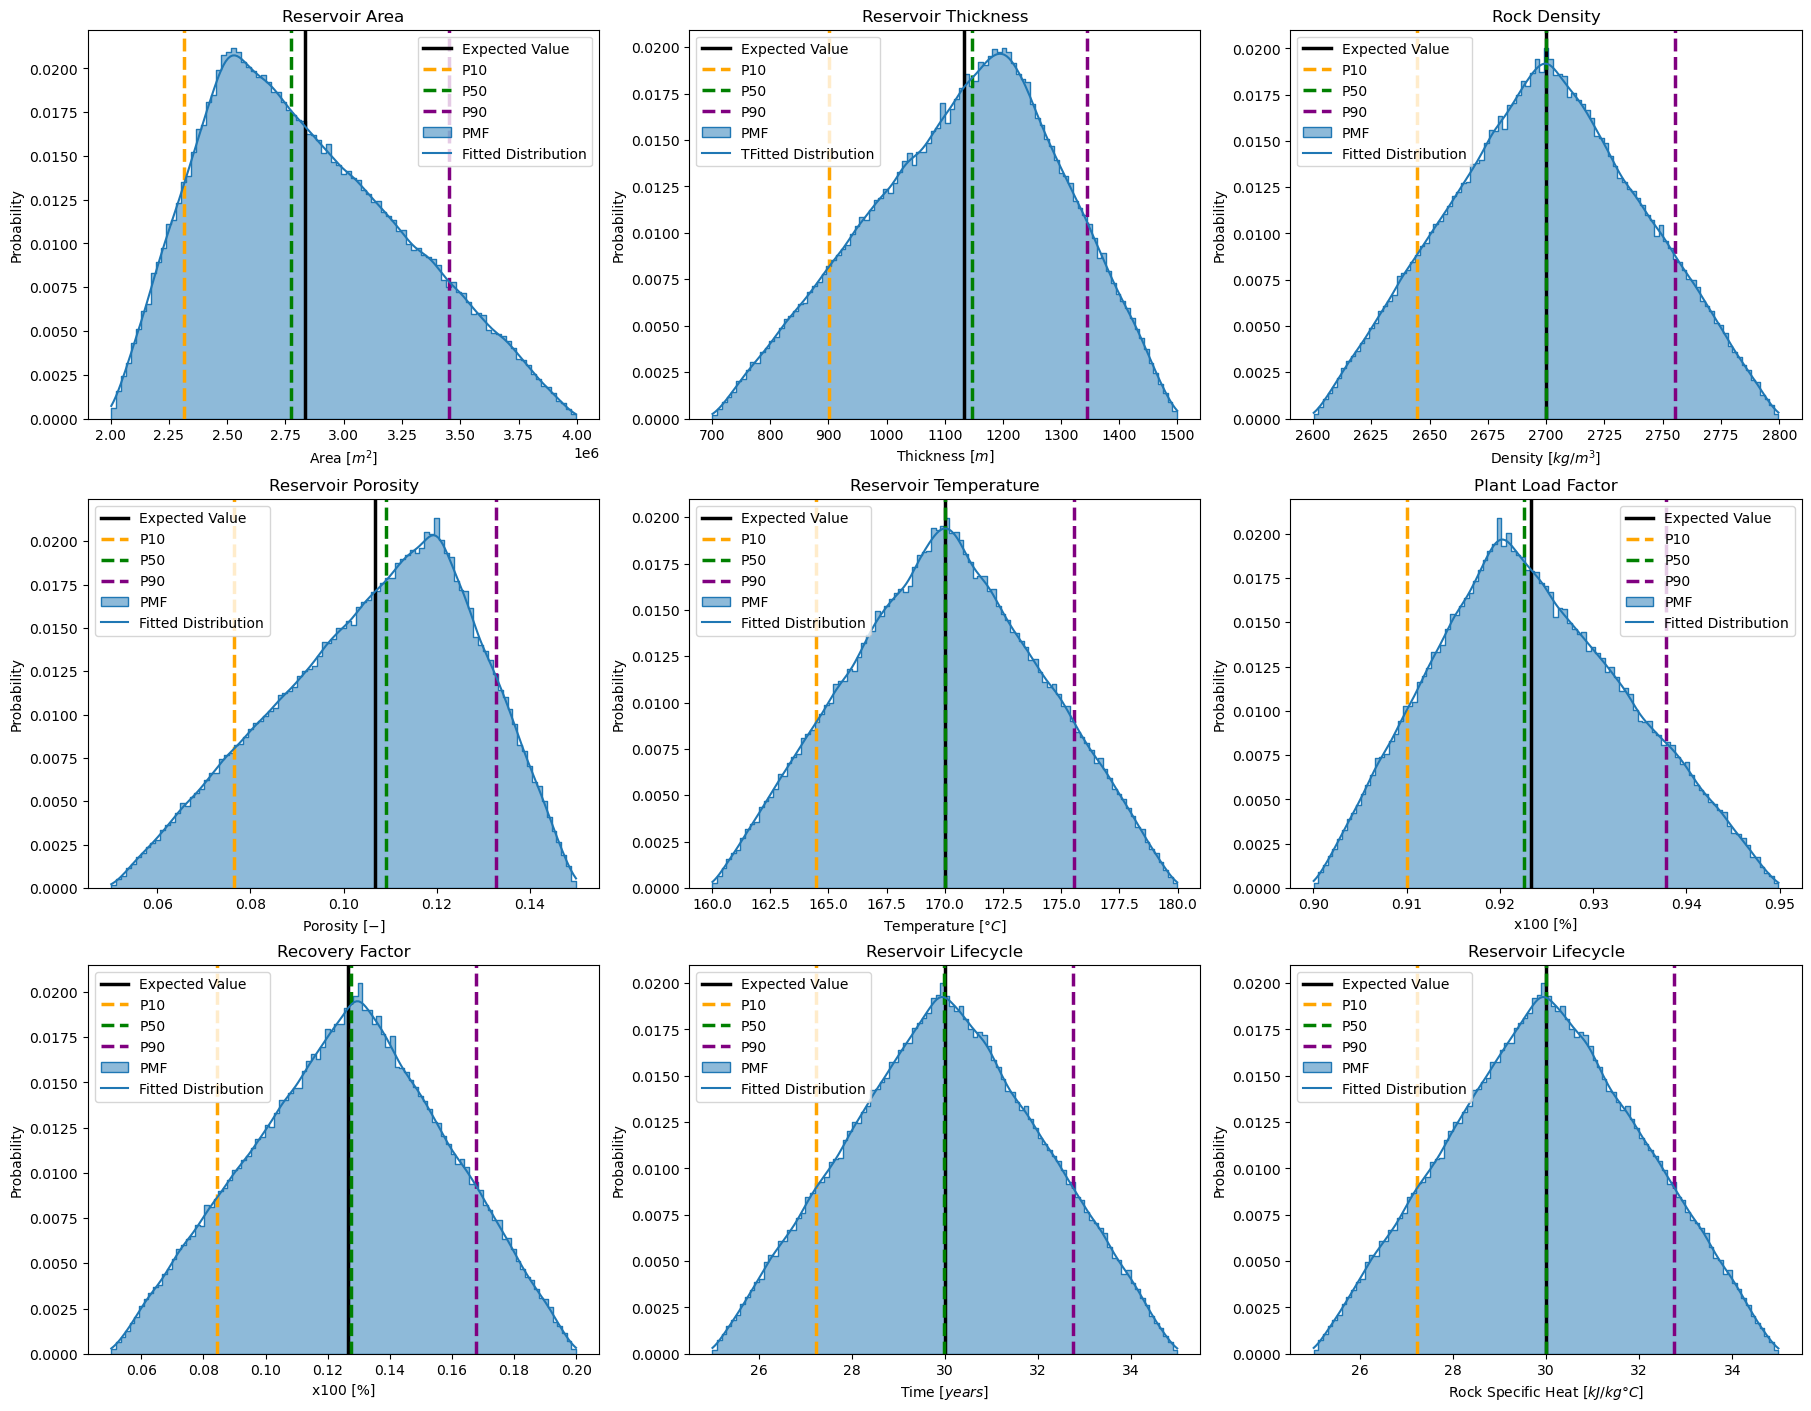

In [8]:
# Plot input distributions

fig, ax = plt.subplots(3, 3, figsize=(18,14), constrained_layout=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = ax.flatten()

# Area
ax1.set_title("Reservoir Area")
ax1.axvline(area.mean(), linewidth=2.5, label="Expected Value", c='black')
ax1.axvline(np.percentile(area, 10), linestyle='--', linewidth=2.5, label="P10", c='orange')
ax1.axvline(np.percentile(area, 50), linestyle='--', linewidth=2.5, label="P50", c='green')
ax1.axvline(np.percentile(area, 90), linestyle='--', linewidth=2.5, label="P90", c='purple')
sns.histplot(area, stat='probability', ax=ax1, kde=True, element = "step", label='PMF', # PMF: probability mass function
             line_kws={'label': "Fitted Distribution"})
ax1.set_xlabel("Area [$m^2$]")
ax1.legend()

# Thickness
ax2.set_title("Reservoir Thickness")
ax2.axvline(thickness.mean(), linewidth=2.5, label="Expected Value", c='black')
ax2.axvline(np.percentile(thickness, 10), linestyle='--', linewidth=2.5, label="P10", c='orange')
ax2.axvline(np.percentile(thickness, 50), linestyle='--', linewidth=2.5, label="P50", c='green')
ax2.axvline(np.percentile(thickness, 90), linestyle='--', linewidth=2.5, label="P90", c='purple')
sns.histplot(thickness, stat='probability', ax=ax2, kde=True, element = "step", label='PMF', # PMF: probability mass function
             line_kws={'label': "TFitted Distribution"})
ax2.set_xlabel("Thickness [$m$]")
ax2.legend()

# Rock density
ax3.set_title("Rock Density")
ax3.axvline(rho_r.mean(), linewidth=2.5, label="Expected Value", c='black')
ax3.axvline(np.percentile(rho_r, 10), linestyle='--', linewidth=2.5, label="P10", c='orange')
ax3.axvline(np.percentile(rho_r, 50), linestyle='--', linewidth=2.5, label="P50", c='green')
ax3.axvline(np.percentile(rho_r, 90), linestyle='--', linewidth=2.5, label="P90", c='purple')
sns.histplot(rho_r, stat='probability', ax=ax3, kde=True, element = "step", label='PMF', # PMF: probability mass function
             line_kws={'label': "Fitted Distribution"})
ax3.set_xlabel("Density [$kg/m^3$]")
ax3.legend(loc="upper left")

# Porosity
ax4.set_title("Reservoir Porosity")
ax4.axvline(phi.mean(), linewidth=2.5, label="Expected Value", c='black')
ax4.axvline(np.percentile(phi, 10), linestyle='--', linewidth=2.5, label="P10", c='orange')
ax4.axvline(np.percentile(phi, 50), linestyle='--', linewidth=2.5, label="P50", c='green')
ax4.axvline(np.percentile(phi, 90), linestyle='--', linewidth=2.5, label="P90", c='purple')
sns.histplot(phi, stat='probability', ax=ax4, kde=True, element = "step", label='PMF', # PMF: probability mass function
             line_kws={'label': "Fitted Distribution"})
ax4.set_xlabel("Porosity [$-$]")
ax4.legend()

# Reservoir temperature
ax5.set_title("Reservoir Temperature")
ax5.axvline(T_i.mean(), linewidth=2.5, label="Expected Value", c='black')
ax5.axvline(np.percentile(T_i, 10), linestyle='--', linewidth=2.5, label="P10", c='orange')
ax5.axvline(np.percentile(T_i, 50), linestyle='--', linewidth=2.5, label="P50", c='green')
ax5.axvline(np.percentile(T_i, 90), linestyle='--', linewidth=2.5, label="P90", c='purple')
sns.histplot(T_i, stat='probability', ax=ax5, kde=True, element = "step", label='PMF', # PMF: probability mass function
             line_kws={'label': "Fitted Distribution"})
ax5.set_xlabel("Temperature [$°C$]")
ax5.legend(loc="upper left")

# Plant load factor
ax6.set_title("Plant Load Factor")
ax6.axvline(PLF.mean(), linewidth=2.5, label="Expected Value", c='black')
ax6.axvline(np.percentile(PLF, 10), linestyle='--', linewidth=2.5, label="P10", c='orange')
ax6.axvline(np.percentile(PLF, 50), linestyle='--', linewidth=2.5, label="P50", c='green')
ax6.axvline(np.percentile(PLF, 90), linestyle='--', linewidth=2.5, label="P90", c='purple')
sns.histplot(PLF, stat='probability', ax=ax6, kde=True, element = "step", label='PMF', # PMF: probability mass function
             line_kws={'label': "Fitted Distribution"})
ax6.set_xlabel("x100 [%]")
ax6.legend()

# Recovery factor
ax7.set_title("Recovery Factor")
ax7.axvline(Rg.mean(), linewidth=2.5, label="Expected Value", c='black')
ax7.axvline(np.percentile(Rg, 10), linestyle='--', linewidth=2.5, label="P10", c='orange')
ax7.axvline(np.percentile(Rg, 50), linestyle='--', linewidth=2.5, label="P50", c='green')
ax7.axvline(np.percentile(Rg, 90), linestyle='--', linewidth=2.5, label="P90", c='purple')
sns.histplot(Rg, stat='probability', ax=ax7, kde=True, element = "step", label='PMF', # PMF: probability mass function
             line_kws={'label': "Fitted Distribution"})
ax7.set_xlabel("x100 [%]")
ax7.legend(loc="upper left")

# Lifecycle
ax8.set_title("Reservoir Lifecycle")
ax8.axvline(t_i.mean(), linewidth=2.5, label="Expected Value", c='black')
ax8.axvline(np.percentile(t_i, 10), linestyle='--', linewidth=2.5, label="P10", c='orange')
ax8.axvline(np.percentile(t_i, 50), linestyle='--', linewidth=2.5, label="P50", c='green')
ax8.axvline(np.percentile(t_i, 90), linestyle='--', linewidth=2.5, label="P90", c='purple')
sns.histplot(t_i, stat='probability', ax=ax8, kde=True, element = "step", label='PMF', # PMF: probability mass function
             line_kws={'label': "Fitted Distribution"})
ax8.set_xlabel("Time [$years$]")
ax8.legend(loc="upper left")

# Lifecycle
ax9.set_title("Reservoir Lifecycle")
ax9.axvline(t_i.mean(), linewidth=2.5, label="Expected Value", c='black')
ax9.axvline(np.percentile(t_i, 10), linestyle='--', linewidth=2.5, label="P10", c='orange')
ax9.axvline(np.percentile(t_i, 50), linestyle='--', linewidth=2.5, label="P50", c='green')
ax9.axvline(np.percentile(t_i, 90), linestyle='--', linewidth=2.5, label="P90", c='purple')
sns.histplot(t_i, stat='probability', ax=ax9, kde=True, element = "step", label='PMF', # PMF: probability mass function
             line_kws={'label': "Fitted Distribution"})
ax9.set_xlabel("Rock Specific Heat [$kJ/kg°C$]")
ax9.legend(loc="upper left");

## Heat in Place Monte Carlo Simulation

In [9]:
# Output simulation using vector operations
Q = ((1 - phi) * c_r * rho_r + phi * c_w * rho_w) * area * thickness * (T_i - T_o) 

### Summary Statistics

#### Confidence Intervals for quantifying uncertainty in the distribution

Let's first demonstrate the calculation of the confidence interval for the sample mean at a 95% confidence level.  This could be interpreted as the interval over which there is a 95% confidence that it contains the true population mean. The student's t-distribution when we do not know the variance and the sample size is small. 

\begin{equation}
CI=x̅ \pm t_{\frac{\alpha}{2},n-1} \times \frac {s}{\sqrt{n}} 
\end{equation}

For this case, we are implementing 200,000 Monte Carlo realizations which make our confidence interval converge to the expected value.

\begin{equation}
CI=x̅ \pm z_{\frac{\alpha}{2}} \times \frac {s}{\sqrt{n}} 
\end{equation}

Hence, a narrow confidence interval is a measure of low uncertainty such that the sample is a good representation of the population mean.

In [10]:
confidenceLvl = 0.95
alphaLvl = 1 - confidenceLvl
zScore = st.norm.ppf(1 - alphaLvl/2) # divide by 2 for two-tailed distribution
lower_bound_95_CI = Q.mean() - zScore * st.sem(Q)
upper_bound_95_CI = Q.mean() + zScore * st.sem(Q)

#ci_95_Q_EJ = st.t.interval(confidence = 0.95, df = n-1, loc=Q_EJ.mean(), scale=st.sem(Q_EJ))
#lower_bound_95_CI = Q_EJ.mean() - ci_95_Q_EJ[0]
#upper_bound_95_CI = Q_EJ.mean() + ci_95_Q_EJ[1]

print('Confidence Level of 95% that', '{:4,.4f} kJ'.format(lower_bound_95_CI), '<', 
      '{:4,.2f} kJ'.format(Q.mean()), '<', '{:4,.2f} kJ'.format(upper_bound_95_CI))

Confidence Level of 95% that 1,287,615,687,071,589.7500 kJ < 1,288,858,857,860,618.00 kJ < 1,290,102,028,649,646.25 kJ


#### Descriptive Statistics
Descriptive statistics summarize the characteristics of a data set. There are three types: distribution, central tendency, and variability.

A percentile is a statistic that identifies the percentage of the data that is less than the given value. The most commonly used percentile is the median. Because it is in the numeric middle of the data, half of the data is below the median.

CDF interpretation:
To determine where the most common values occur, look for the steeper portions of the step function. Conversely, flatter portions indicate ranges with fewer observations. Steeper slopes indicate a tighter range of values and, therefore, lower variability. You can also assess the mean and standard deviation values in the legend to derive similar conclusions. https://statisticsbyjim.com/graphs/empirical-cumulative-distribution-function-cdf-plots/

In [11]:
# Descriptive Statistics

Q_pmean = percentileofscore(Q, Q.mean()) # percentile value of the mean
print('                      Standard Deviation = {:4,.2f} kJ'.format(Q.std()))
print('                     Expected Value: P{:1,.0f}'.format(Q_pmean),'= {:4,.2f} kJ'.format(Q.mean()))
print('                                     P10 = {:4,.2f} kJ'.format(np.percentile(Q, 10)))
print('                                     P50 = {:4,.2f} kJ'.format(np.percentile(Q, 50)))
print('                                     P90 = {:4,.2f} kJ'.format(np.percentile(Q, 90)))
#print('                         Prob. of no HIP = {:.3f} %'.format(np.sum((Q < 0) / n) * 100))
#print('      Prob. of Stored Energy > 2.5e15 kJ = {:.3f} %'.format(np.sum((Q > 2.5e15) / n) * 100))

                      Standard Deviation = 283,659,032,950,744.06 kJ
                     Expected Value: P53 = 1,288,858,857,860,618.00 kJ
                                     P10 = 940,512,288,200,141.12 kJ
                                     P50 = 1,264,295,728,985,164.50 kJ
                                     P90 = 1,673,936,929,591,082.75 kJ


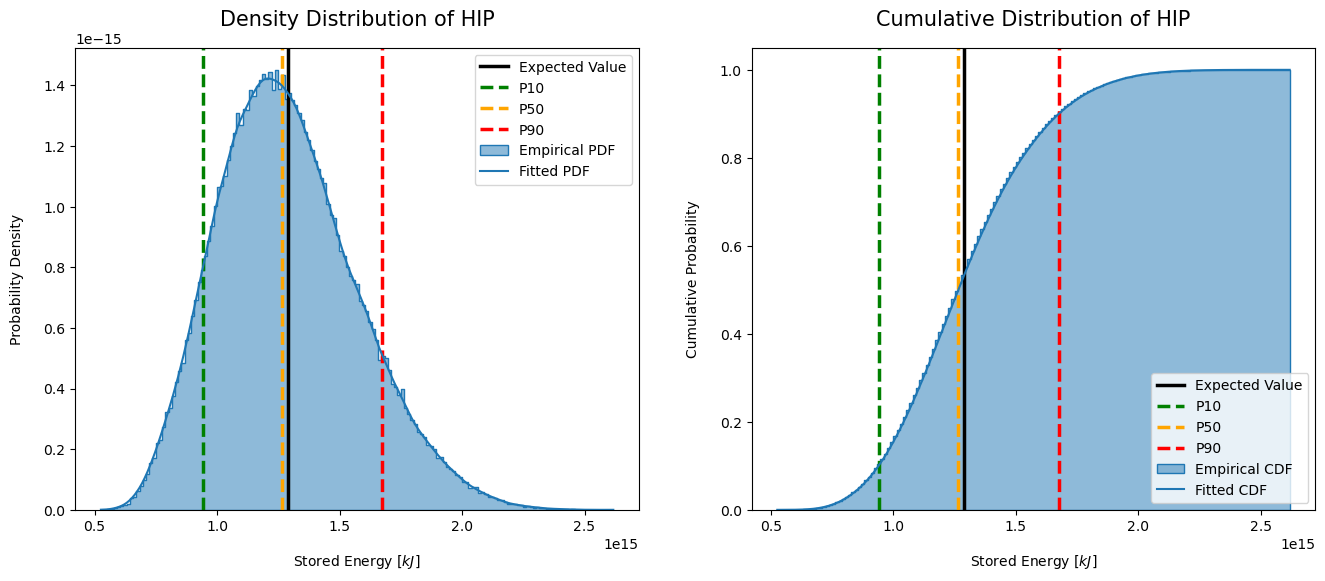

In [12]:
# PMF – probability of data falling within each bin relative to the total number of bins https://likegeeks.com/seaborn-histplot-stat/
#plt.title("PMF of HIP", y=1.03, fontsize=15)
#sns.histplot(Q_EJ, stat='probability', element = "step")
#plt.xlabel("Stored Energy [$EJ$]", labelpad=14)
#plt.ylabel("Probability", labelpad=14);

# Plot PDF – area of histogram sums to one
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title("Density Distribution of HIP", y=1.03, fontsize=15)
#plt.axvline(lower_bound_95_CI, linestyle='--', linewidth=2.5, label="lower bound 95% CI", c='orange')
#plt.axvline(upper_bound_95_CI, linestyle='--', linewidth=2.5, label="upper bound 95% CI", c='purple')
ax1.axvline(Q.mean(), linewidth=2.5, label="Expected Value", c='black')
ax1.axvline(np.percentile(Q, 10), linestyle='--', linewidth=2.5, label="P10", c='green')
ax1.axvline(np.percentile(Q, 50), linestyle='--', linewidth=2.5, label="P50", c='orange')
ax1.axvline(np.percentile(Q, 90), linestyle='--', linewidth=2.5, label="P90", c='red')
sns.histplot(Q, stat='density', ax=ax1, kde=True, element = "step", label='Empirical PDF', 
             line_kws={'label': "Fitted PDF"})
#ax.lines[3].set_color('grey')
ax1.set_xlabel("Stored Energy [$kJ$]", labelpad=14)
ax1.set_ylabel("Probability Density", labelpad=14)
ax1.legend()

# Plot CDF – probability of X < value
ax2.set_title("Cumulative Distribution of HIP", y=1.03, fontsize=15)
ax2.axvline(Q.mean(), linewidth=2.5, label="Expected Value", c='black')
ax2.axvline(np.percentile(Q, 10), linestyle='--', linewidth=2.5, label="P10", c='green')
ax2.axvline(np.percentile(Q, 50), linestyle='--', linewidth=2.5, label="P50", c='orange')
ax2.axvline(np.percentile(Q, 90), linestyle='--', linewidth=2.5, label="P90", c='red')
sns.histplot(Q, stat='probability', ax=ax2, fill=True, element='step', cumulative=True, kde=True, 
             label="Empirical CDF", line_kws={'label': "Fitted CDF"}) 
#ax.lines[1].set_color('grey')
ax2.set_xlabel("Stored Energy [$kJ$]", labelpad=14)
ax2.set_ylabel("Cumulative Probability", labelpad=14)
#ax2.text(0.6e15, 0.99, 'matplotlib', ha='left', va='top')
ax2.legend();

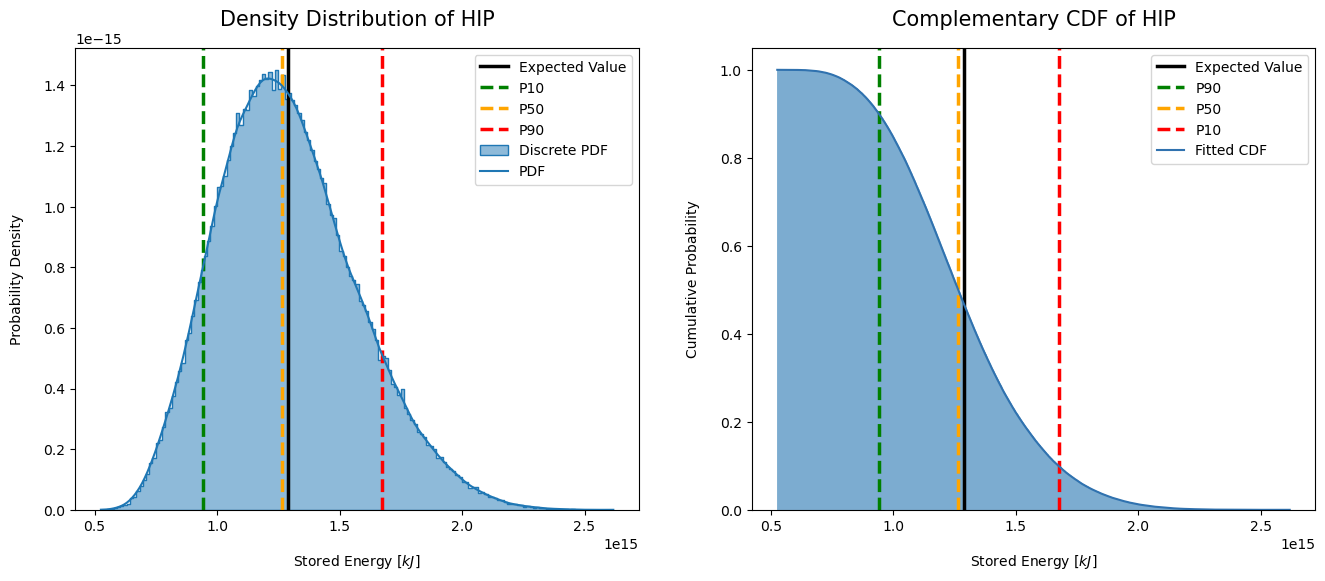

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title("Density Distribution of HIP", y=1.03, fontsize=15)
#plt.axvline(lower_bound_95_CI, linestyle='--', linewidth=2.5, label="lower bound 95% CI", c='orange')
#plt.axvline(upper_bound_95_CI, linestyle='--', linewidth=2.5, label="upper bound 95% CI", c='purple')
ax1.axvline(Q.mean(), linewidth=2.5, label="Expected Value", c='black')
ax1.axvline(np.percentile(Q, 10), linestyle='--', linewidth=2.5, label="P10", c='green')
ax1.axvline(np.percentile(Q, 50), linestyle='--', linewidth=2.5, label="P50", c='orange')
ax1.axvline(np.percentile(Q, 90), linestyle='--', linewidth=2.5, label="P90", c='red')
ax = sns.histplot(Q, stat='density', ax=ax1, kde=True, element = "step", label='Discrete PDF', 
             line_kws={'label': "PDF"}).get_lines()[0].get_data()
#ax.lines[3].set_color('grey')
ax1.set_xlabel("Stored Energy [$kJ$]", labelpad=14)
ax1.set_ylabel("Probability Density", labelpad=14)
ax1.legend()

# Plot CDF – probability of X < value
ax2.set_title("Complementary CDF of HIP", y=1.03, fontsize=15)
ax2.axvline(Q.mean(), linewidth=2.5, label="Expected Value", c='black')
ax2.axvline(np.percentile(Q, 10), linestyle='--', linewidth=2.5, label="P90", c='green')
ax2.axvline(np.percentile(Q, 50), linestyle='--', linewidth=2.5, label="P50", c='orange')
ax2.axvline(np.percentile(Q, 90), linestyle='--', linewidth=2.5, label="P10", c='red')
#sns.histplot(Q, stat='probability', ax=ax2, fill=True, element='step', cumulative=True, kde=True, 
            # label="Discrete CDF", line_kws={'label': "CDF"}) 
#ax.lines[1].set_color('grey')
ax2.set_xlabel("Stored Energy [$kJ$]", labelpad=14)
ax2.set_ylabel("Cumulative Probability", labelpad=14)
Q_sorted = np.sort(Q)
kde = 1 - np.arange(len(Q_sorted))/float(len(Q_sorted))
ax2.plot(Q_sorted, kde, color='#3072af', label="Fitted CDF",)
ax2.fill_between(Q_sorted, kde, 0, color='#7cacd0')
ax2.set_ylim(ymin=0)
ax2.legend();

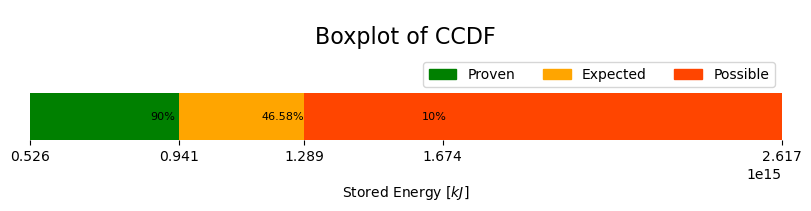

In [14]:
# Boxplot of Complentary CDF
# https://stackoverflow.com/questions/55119952/how-to-draw-a-horizontal-percentage-bar-plot-with-matplotlib
fig, ax = plt.subplots(figsize=(8,2), constrained_layout=True)

start = Q.min()
Proven = np.percentile(Q, 10)
Expected = Q.mean()
Possible = Q.max()

ax.broken_barh([(start, Proven), (Proven, Expected), (Expected, Possible)], [10, 9], facecolors=('green', 'orange', 'orangered'))
ax.set_ylim(10, 35)
ax.set_xlim(Q.min(), Q.max())
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(None)
ax.set_yticks([])
ax.tick_params(left=False)
ax.set_xticks([Q.min(), Proven, Q.mean(), np.percentile(Q, 90), Q.max()])
ax.set_axisbelow(True) 

#ax.set_yticklabels(['Q1'])
ax.grid(axis='x')
ax.text(Proven-0.8e14, 14, "90%", fontsize=8)
ax.text((Proven+Expected)-10.6e14, 14, '{:4,.2f}%'.format(100-Q_pmean), fontsize=8)
ax.text((Proven+Expected+Possible)-3.23e15, 14, "10%", fontsize=8)

fig.suptitle('Boxplot of CCDF', fontsize=16, y=0.9)

leg1 = mpatches.Patch(color='green', label='Proven')
leg2 = mpatches.Patch(color='orange', label='Expected')
leg3 = mpatches.Patch(color='orangered', label='Possible')
ax.set_xlabel("Stored Energy [$kJ$]", labelpad=14)
ax.legend(loc='center right', handles=[leg1, leg2, leg3], ncol=3);

## Energy Recovery Analysis

In [15]:
# Find the energy at the wellhead
Q_wh = Rg * Q

In [16]:
# Descriptive Statistics

Q_wh_pmean = percentileofscore(Q_wh, Q_wh.mean()) # percentile value of the mean
print('                      Standard Deviation = {:4,.2f} kJ'.format(Q_wh.std()))
print('                     Expected Value: P{:1,.0f}'.format(Q_wh_pmean),'= {:4,.2f} kJ'.format(Q_wh.mean()))
print('                                     P10 = {:4,.2f} kJ'.format(np.percentile(Q_wh, 10)))
print('                                     P50 = {:4,.2f} kJ'.format(np.percentile(Q_wh, 50)))
print('                                     P90 = {:4,.2f} kJ'.format(np.percentile(Q_wh, 90)))

                      Standard Deviation = 54,091,272,275,857.98 kJ
                     Expected Value: P54 = 163,193,295,634,530.00 kJ
                                     P10 = 97,584,240,622,538.73 kJ
                                     P50 = 157,664,995,788,935.50 kJ
                                     P90 = 235,863,574,683,098.44 kJ


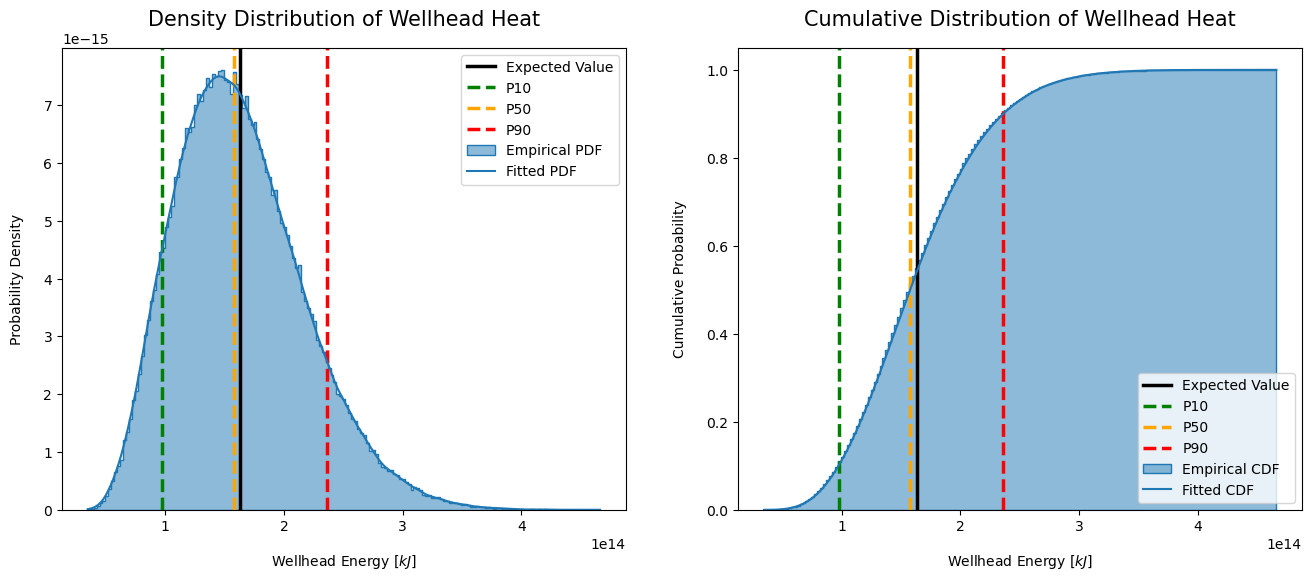

In [17]:
# Plot PDF – area of histogram sums to one
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title("Density Distribution of Wellhead Heat", y=1.03, fontsize=15)
#plt.axvline(lower_bound_95_CI, linestyle='--', linewidth=2.5, label="lower bound 95% CI", c='orange')
#plt.axvline(upper_bound_95_CI, linestyle='--', linewidth=2.5, label="upper bound 95% CI", c='purple')
ax1.axvline(Q_wh.mean(), linewidth=2.5, label="Expected Value", c='black')
ax1.axvline(np.percentile(Q_wh, 10), linestyle='--', linewidth=2.5, label="P10", c='green')
ax1.axvline(np.percentile(Q_wh, 50), linestyle='--', linewidth=2.5, label="P50", c='orange')
ax1.axvline(np.percentile(Q_wh, 90), linestyle='--', linewidth=2.5, label="P90", c='red')
sns.histplot(Q_wh, stat='density', ax=ax1, kde=True, element = "step", label='Empirical PDF', 
             line_kws={'label': "Fitted PDF"})
#ax.lines[3].set_color('grey')
ax1.set_xlabel("Wellhead Energy [$kJ$]", labelpad=14)
ax1.set_ylabel("Probability Density", labelpad=14)
ax1.legend()

# Plot CDF – probability of X < value
ax2.set_title("Cumulative Distribution of Wellhead Heat", y=1.03, fontsize=15)
ax2.axvline(Q_wh.mean(), linewidth=2.5, label="Expected Value", c='black')
ax2.axvline(np.percentile(Q_wh, 10), linestyle='--', linewidth=2.5, label="P10", c='green')
ax2.axvline(np.percentile(Q_wh, 50), linestyle='--', linewidth=2.5, label="P50", c='orange')
ax2.axvline(np.percentile(Q_wh, 90), linestyle='--', linewidth=2.5, label="P90", c='red')
sns.histplot(Q_wh, stat='probability', ax=ax2, fill=True, element='step', cumulative=True, kde=True, 
             label="Empirical CDF", line_kws={'label': "Fitted CDF"})
#ax.lines[1].set_color('grey')
ax2.set_xlabel("Wellhead Energy [$kJ$]", labelpad=14)
ax2.set_ylabel("Cumulative Probability", labelpad=14)
ax2.legend();

In [18]:
# Find the Available Energy for Work (Exergy) for the lifecycle

V = area * thickness # compute the total volume
#m = V * phi * rho_w # fluid mass at entire reservoir

# Find the total fluid mass produced at wellhead
m_wh = Q_wh / (h_wh - h_o)

# Find the specific exergy
e = h_wh - h_o - T_o * (s_wh - s_o)

In [19]:
# Compute for available work and power 
W_a = m_wh * e # [kJ]
P_a = W_a / (t_i * 365 * 24 * 60 * 60) / 1000 # (years * days/year * hours/day * min/hour * sec/min) [MW]

In [20]:
# Descriptive Statistics

P_a_pmean = percentileofscore(P_a, P_a.mean()) # percentile value of the mean
print('                      Standard Deviation = {:4,.2f} MW'.format(P_a.std()))
print('                     Expected Value: P{:1,.0f}'.format(P_a_pmean),'= {:4,.2f} MW'.format(P_a.mean()))
print('                                     P10 = {:4,.2f} MW'.format(np.percentile(P_a, 10)))
print('                                     P50 = {:4,.2f} MW'.format(np.percentile(P_a, 50)))
print('                                     P90 = {:4,.2f} MW'.format(np.percentile(P_a, 90)))

                      Standard Deviation = 55.87 MW
                     Expected Value: P54 = 164.73 MW
                                     P10 = 97.59 MW
                                     P50 = 158.58 MW
                                     P90 = 239.75 MW


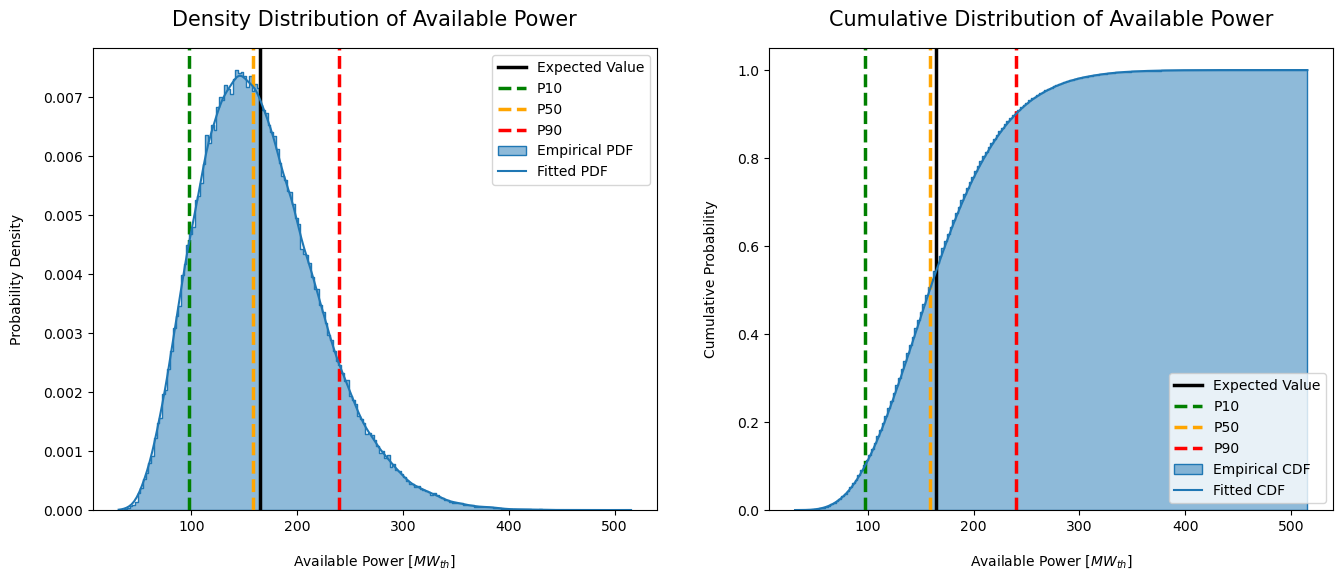

In [21]:
# Plot PDF – area of histogram sums to one
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title("Density Distribution of Available Power", y=1.03, fontsize=15)
#plt.axvline(lower_bound_95_CI, linestyle='--', linewidth=2.5, label="lower bound 95% CI", c='orange')
#plt.axvline(upper_bound_95_CI, linestyle='--', linewidth=2.5, label="upper bound 95% CI", c='purple')
ax1.axvline(P_a.mean(), linewidth=2.5, label="Expected Value", c='black')
ax1.axvline(np.percentile(P_a, 10), linestyle='--', linewidth=2.5, label="P10", c='green')
ax1.axvline(np.percentile(P_a, 50), linestyle='--', linewidth=2.5, label="P50", c='orange')
ax1.axvline(np.percentile(P_a, 90), linestyle='--', linewidth=2.5, label="P90", c='red')
sns.histplot(P_a, stat='density', ax=ax1, kde=True, element = "step", label='Empirical PDF', 
             line_kws={'label': "Fitted PDF"})
#ax.lines[3].set_color('grey')
ax1.set_xlabel("Available Power [$MW_{th}$]", labelpad=14)
ax1.set_ylabel("Probability Density", labelpad=14)
ax1.legend()

# Plot CDF – probability of X < value
ax2.set_title("Cumulative Distribution of Available Power", y=1.03, fontsize=15)
ax2.axvline(P_a.mean(), linewidth=2.5, label="Expected Value", c='black')
ax2.axvline(np.percentile(P_a, 10), linestyle='--', linewidth=2.5, label="P10", c='green')
ax2.axvline(np.percentile(P_a, 50), linestyle='--', linewidth=2.5, label="P50", c='orange')
ax2.axvline(np.percentile(P_a, 90), linestyle='--', linewidth=2.5, label="P90", c='red')
sns.histplot(P_a, stat='probability', ax=ax2, fill=True, element='step', cumulative=True, kde=True, 
             label="Empirical CDF", line_kws={'label': "Fitted CDF"}) 
#ax.lines[1].set_color('grey')
ax2.set_xlabel("Available Power [$MW_{th}$]", labelpad=14)
ax2.set_ylabel("Cumulative Probability", labelpad=14)
ax2.legend();

## Capacity Utilization Factor (Plant Load Factor)
The CUF (PLF) is defined as the ratio of the actual output from a power plant over the year to the maximum possible output from it for a year under ideal conditions.
$PLF = MWh / (MW_{max} \times hr_{year}) $

In [22]:
# Find the Produceable Electrical Energy

W_e = eta * W_a # [kJ]
P_e = W_e / (PLF * t_i * 365 * 24 * 60 * 60) / 1000 # (years * days/year * hours/day * min/hour * sec/min) / [MW]

In [23]:
# Descriptive Statistics

P_e_pmean = percentileofscore(P_e, P_e.mean()) # percentile value of the mean
print('                      Standard Deviation = {:4,.2f} MW'.format(P_e.std()))
print('                     Expected Value: P{:1,.0f}'.format(P_e_pmean),'= {:4,.2f} MW'.format(P_e.mean()))
print('                                     P10 = {:4,.2f} MW'.format(np.percentile(P_e, 10)))
print('                                     P50 = {:4,.2f} MW'.format(np.percentile(P_e, 50)))
print('                                     P90 = {:4,.2f} MW'.format(np.percentile(P_e, 90)))

                      Standard Deviation = 20.43 MW
                     Expected Value: P54 = 59.80 MW
                                     P10 = 35.33 MW
                                     P50 = 57.52 MW
                                     P90 = 87.22 MW


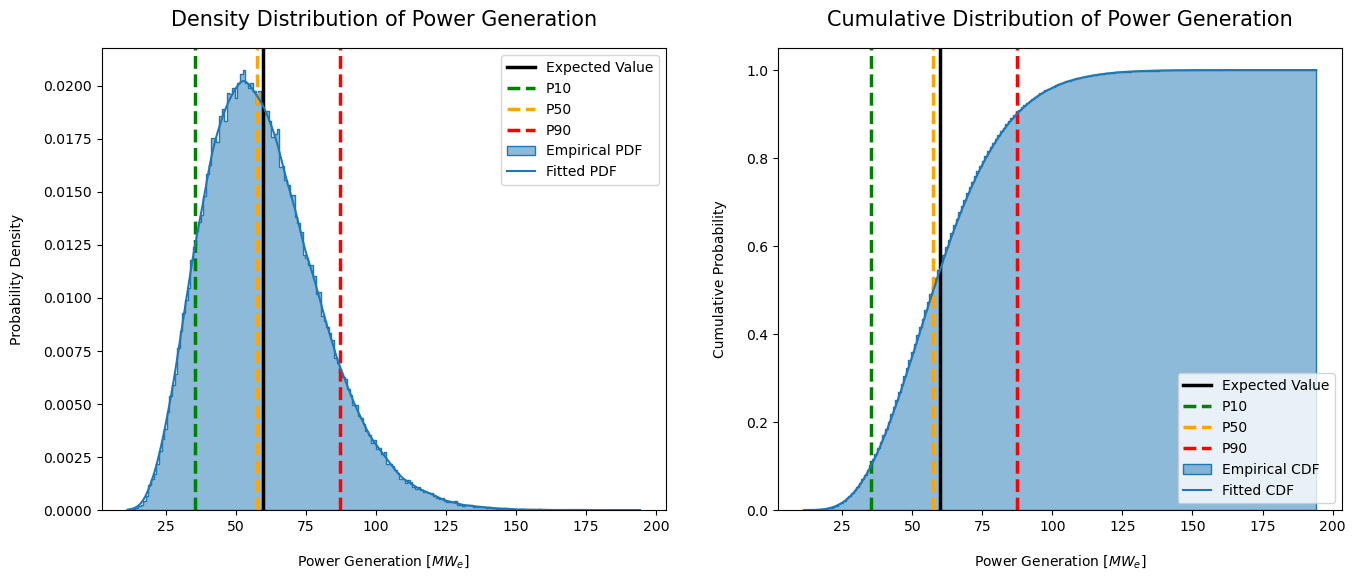

In [24]:
# Plot PDF – area of histogram sums to one
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title("Density Distribution of Power Generation", y=1.03, fontsize=15)
#plt.axvline(lower_bound_95_CI, linestyle='--', linewidth=2.5, label="lower bound 95% CI", c='orange')
#plt.axvline(upper_bound_95_CI, linestyle='--', linewidth=2.5, label="upper bound 95% CI", c='purple')
ax1.axvline(P_e.mean(), linewidth=2.5, label="Expected Value", c='black')
ax1.axvline(np.percentile(P_e, 10), linestyle='--', linewidth=2.5, label="P10", c='green')
ax1.axvline(np.percentile(P_e, 50), linestyle='--', linewidth=2.5, label="P50", c='orange')
ax1.axvline(np.percentile(P_e, 90), linestyle='--', linewidth=2.5, label="P90", c='red')
sns.histplot(P_e, stat='density', ax=ax1, kde=True, element = "step", label='Empirical PDF', 
             line_kws={'label': "Fitted PDF"})
#ax.lines[3].set_color('grey')
ax1.set_xlabel("Power Generation [$MW_{e}$]", labelpad=14)
ax1.set_ylabel("Probability Density", labelpad=14)
ax1.legend()

# Plot CDF – probability of X < value
ax2.set_title("Cumulative Distribution of Power Generation", y=1.03, fontsize=15)
ax2.axvline(P_e.mean(), linewidth=2.5, label="Expected Value", c='black')
ax2.axvline(np.percentile(P_e, 10), linestyle='--', linewidth=2.5, label="P10", c='green')
ax2.axvline(np.percentile(P_e, 50), linestyle='--', linewidth=2.5, label="P50", c='orange')
ax2.axvline(np.percentile(P_e, 90), linestyle='--', linewidth=2.5, label="P90", c='red')
sns.histplot(P_e, stat='probability', ax=ax2, fill=True, element='step', cumulative=True, kde=True, 
             label="Empirical CDF", line_kws={'label': "Fitted CDF"}) 
#ax.lines[1].set_color('grey')
ax2.set_xlabel("Power Generation [$MW_{e}$]", labelpad=14)
ax2.set_ylabel("Cumulative Probability", labelpad=14)
ax2.legend();

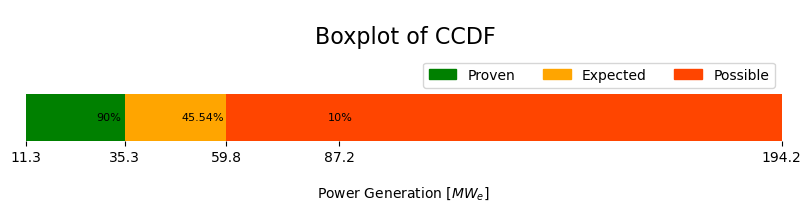

In [27]:
fig, ax = plt.subplots(figsize=(8,2), constrained_layout=True)

start = P_e.min()
Proven = np.percentile(P_e, 10)
Expected = P_e.mean()
Possible = P_e.max()

ax.broken_barh([(start, Proven), (Proven, Expected), (Expected, Possible)], [10, 9], facecolors=('green', 'orange', 'orangered'))
ax.set_ylim(10, 35)
ax.set_xlim(P_e.min(), P_e.max())
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(None)
ax.set_yticks([])
ax.tick_params(left=False)
ax.set_xticks([P_e.min(), Proven, P_e.mean(), np.percentile(P_e, 90), P_e.max()])
ax.set_axisbelow(True) 

#ax.set_yticklabels(['Q1'])
ax.grid(axis='x')
ax.text(Proven-7, 14, "90%", fontsize=8)
ax.text((Proven+Expected)-46, 14, '{:4,.2f}%'.format(100-P_e_pmean), fontsize=8)
ax.text((Proven+Expected+Possible)-205, 14, "10%", fontsize=8)

fig.suptitle('Boxplot of CCDF', fontsize=16, y=0.9)

leg1 = mpatches.Patch(color='green', label='Proven')
leg2 = mpatches.Patch(color='orange', label='Expected')
leg3 = mpatches.Patch(color='orangered', label='Possible')
ax.set_xlabel("Power Generation [$MW_{e}$]", labelpad=14)
ax.legend(loc='center right', handles=[leg1, leg2, leg3], ncol=3);

## Simulation Summary Dataframe

In [43]:
# Create dataframe of inputs and outputs
df = pd.DataFrame({'Reservoir Area': area, 'Reservoir Thickness': thickness, 'Rock Density': rho_r,
                   'Reservoir Pososity': phi, 'Reservoir Temperature': T_i, 'Plant Load Factor': PLF, 
                   'Recovery Factor': Rg, 'Reservoir Lifecycle': t_i, 'Rock Specific Heat': c_r, 
                   'Stored Heat': Q, 'Wellhead Heat': Q_wh, 'Available Power': P_a, 
                   'Produceable Electricity': P_e, 'Reservoir Volume': V})

# Create dataframe of summary statistics
stats = df.describe(percentiles=[0.10, 0.50, 0.90]).transpose() # transpose axes for better representation
stats.reset_index(inplace=True) # add the index to the dataframe
stats = stats.rename(columns={"index": "Parameter"})
stats

,Parameter,count,mean,std,min,10%,50%,90%,max
0,Reservoir Area,200000.0,2.833146e+06,4.247532e+05,2.000599e+06,2.317381e+06,2.773248e+06,3.451215e+06,3.992355e+06
1,Reservoir Thickness,200000.0,1.133530e+03,1.649917e+02,7.010359e+02,8.995681e+02,1.147799e+03,1.344776e+03,1.499483e+03
2,Rock Density,200000.0,2.700088e+03,4.080150e+01,2.600082e+03,2.644920e+03,2.699986e+03,2.755249e+03,2.799891e+03
3,Reservoir Pososity,200000.0,1.066199e-01,2.096374e-02,5.007409e-02,7.637841e-02,1.091238e-01,1.326539e-01,1.498856e-01
4,Reservoir Temperature,200000.0,1.699808e+02,4.082419e+00,1.600401e+02,1.644726e+02,1.699711e+02,1.755237e+02,1.799939e+02
5,Plant Load Factor,200000.0,9.232894e-01,1.027929e-02,9.000752e-01,9.099389e-01,9.225663e-01,9.377070e-01,9.499504e-01
6,Recovery Factor,200000.0,1.265874e-01,3.068522e-02,5.046064e-02,8.456413e-02,1.274358e-01,1.675040e-01,1.997948e-01
7,Reservoir Lifecycle,200000.0,3.000193e+01,2.042245e+00,2.500735e+01,2.724068e+01,2.999717e+01,3.277502e+01,3.497994e+01
8,Rock Specific Heat,200000.0,9.465000e-01,6.326349e-02,7.903799e-01,8.604390e-01,9.472341e-01,1.031815e+00,1.099464e+00
9,Stored Heat,200000.0,1.289013e+15,2.842735e+14,5.583265e+14,9.394226e+14,1.263662e+15,1.674916e+15,2.686464e+15


## Sensitivity Analysis – Tornado Diagram
The Tornado Diagram calculates the sensitivity (low and high values) each input has on the output by keeping the other inputs at their baseline.

In [44]:
# Stored Heat Tornado Diagram (made with baseline values not the mean values of the simulation)

# Input series as a function of reservoir temperature
# water density
rho_w_min = np.interp(T_i_a, T, rho_H20)
rho_w_base = np.interp(T_i_b, T, rho_H20)
rho_w_max = np.interp(T_i_c, T, rho_H20)
# water specific heat
c_w_min = np.interp(T_i_a, T, c_H20)
c_w_base = np.interp(T_i_b, T, c_H20) 
c_w_max = np.interp(T_i_c, T, c_H20)

# Stored Heat Baseline
Q_base = ((1 - phi_b) * c_r_b * rho_r_b + phi_b * c_w_base * rho_w_base) * area_b * thickness_b * (T_i_b - T_o) / 1000000000000

# Area
Q_areaLow = ((1 - phi_b) * c_r_b * rho_r_b + phi_b * c_w_base * rho_w_base) * area_a * thickness_b * (T_i_b - T_o) / 1000000000000
Q_areaHigh = ((1 - phi_b) * c_r_b * rho_r_b + phi_b * c_w_base * rho_w_base) * area_c * thickness_b * (T_i_b - T_o) / 1000000000000
Q_areaSwing = Q_areaHigh - Q_areaLow

# Thickness
Q_thicknessLow = ((1 - phi_b) * c_r_b * rho_r_b + phi_b * c_w_base * rho_w_base) * area_b * thickness_a * (T_i_b - T_o) / 1000000000000
Q_thicknessHigh = ((1 - phi_b) * c_r_b * rho_r_b + phi_b * c_w_base * rho_w_base) * area_b * thickness_c * (T_i_b - T_o) / 1000000000000
Q_thicknessSwing = Q_thicknessHigh - Q_thicknessLow

# Rock Density
Q_rho_rLow = ((1 - phi_b) * c_r_b * rho_r_a + phi_b * c_w_base * rho_w_base) * area_b * thickness_b * (T_i_b - T_o) / 1000000000000
Q_rho_rHigh = ((1 - phi_b) * c_r_b * rho_r_c + phi_b * c_w_base * rho_w_base) * area_b * thickness_b * (T_i_b - T_o) / 1000000000000
Q_rho_rSwing = Q_rho_rHigh - Q_rho_rLow

# Reservoir Porosity
Q_phiLow = ((1 - phi_a) * c_r_b * rho_r_b + phi_a * c_w_base * rho_w_base) * area_b * thickness_b * (T_i_b - T_o) / 1000000000000
Q_phiHigh = ((1 - phi_c) * c_r_b * rho_r_b + phi_c * c_w_base * rho_w_base) * area_b * thickness_b * (T_i_b - T_o) / 1000000000000
Q_phiSwing = Q_phiHigh - Q_phiLow

# Reservoir Temperature
Q_T_iLow = ((1 - phi_b) * c_r_b * rho_r_b + phi_b * c_w_min * rho_w_min) * area_b * thickness_b * (T_i_a - T_o) / 1000000000000
Q_T_iHigh = ((1 - phi_b) * c_r_b * rho_r_b + phi_b * c_w_max * rho_w_max) * area_b * thickness_b * (T_i_c - T_o) / 1000000000000
Q_T_iSwing = Q_T_iHigh - Q_T_iLow

# Rock Specific Heat
Q_c_rLow = ((1 - phi_b) * c_r_a * rho_r_b + phi_b * c_w_base * rho_w_base) * area_b * thickness_b * (T_i_b - T_o) / 1000000000000
Q_c_rHigh = ((1 - phi_b) * c_r_c * rho_r_b + phi_b * c_w_base * rho_w_base) * area_b * thickness_b * (T_i_b - T_o) / 1000000000000
Q_c_rSwing = Q_c_rHigh - Q_c_rLow

# Values were converted from kJ to PJ (kJ/1e12) for ease of display

In [45]:
# Create stored heat sensitivity analysis dataframe

d = pd.DataFrame({'Parameter': [stats['Parameter'][0], stats['Parameter'][1], stats['Parameter'][8],
                                stats['Parameter'][4], stats['Parameter'][2], stats['Parameter'][3]],
     'Base Input': [area_b, thickness_b, c_r_b, T_i_b, rho_r_b, phi_b],
     'Low Input': [area_a, thickness_a, c_r_a, T_i_a, rho_r_a, phi_a],
     'Low Output': [Q_areaLow, Q_thicknessLow, Q_c_rLow, Q_T_iLow, Q_rho_rLow, Q_phiLow],
     'High Input': [area_c, thickness_c, c_r_c, T_i_c, rho_r_c, phi_c],
     'High Output': [Q_areaHigh, Q_thicknessHigh, Q_T_iHigh, Q_c_rHigh, Q_rho_rHigh, Q_phiHigh],
     'Swing': [Q_areaSwing, Q_thicknessSwing, Q_c_rSwing, Q_T_iSwing, Q_rho_rSwing, Q_phiSwing]})
#d.columns = pd.MultiIndex.from_product([['Stored Heat Sensitivity – Baseline: {:4,.2f} PJ'.format(Q_base)], d.columns])
print('Stored Heat Sensitivity – Baseline: {:10,.2f} PJ'.format(Q_base))
d

Stored Heat Sensitivity – Baseline:   1,212.89 PJ


,Parameter,Base Input,Low Input,Low Output,High Input,High Output,Swing
0,Reservoir Area,2500000.00,2000000.00,970.312404,4000000.00,1940.624808,970.312404
1,Reservoir Thickness,1200.00,700.00,707.519461,1500.00,1516.113131,808.593670
2,Rock Specific Heat,0.95,0.79,1039.537545,1.10,1290.008325,335.871360
3,Reservoir Temperature,170.00,160.00,1135.448378,180.00,1375.408905,154.559948
4,Rock Density,2700.00,2600.00,1174.768905,2800.00,1251.012105,76.243200
5,Reservoir Pososity,0.12,0.05,1187.661044,0.15,1223.703131,36.042087


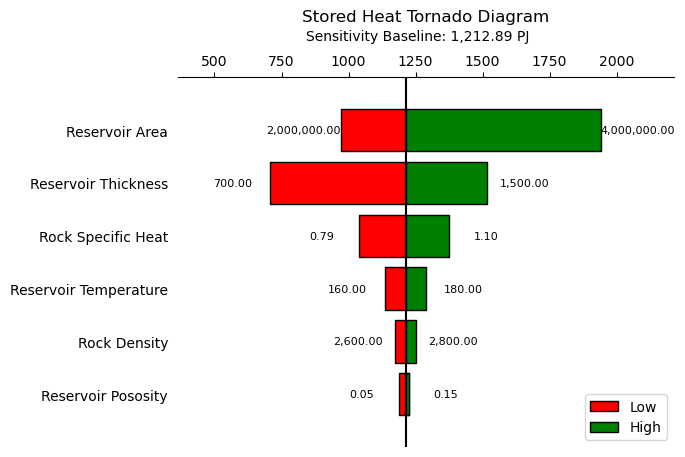

In [46]:
# Adapted from https://stackoverflow.com/questions/32132773/a-tornado-chart-and-p10-p90-in-python-matplotlib
variables = [stats['Parameter'][0], stats['Parameter'][1], stats['Parameter'][8],
             stats['Parameter'][4], stats['Parameter'][2], stats['Parameter'][3]]

base = Q_base

# low values
lin = np.array([area_a, thickness_a, c_r_a, T_i_a, rho_r_a, phi_a])
lows = np.array([Q_areaLow, Q_thicknessLow, Q_c_rLow, Q_T_iLow, Q_rho_rLow, Q_phiLow])

# high values
hin = np.array([area_c, thickness_c, c_r_c, T_i_c, rho_r_c, phi_c])
highs = np.array([Q_areaHigh, Q_thicknessHigh, Q_c_rHigh, Q_T_iHigh, Q_rho_rHigh, Q_phiHigh])

# swing
values = np.array([Q_areaSwing, Q_thicknessSwing, Q_c_rSwing, Q_T_iSwing, Q_rho_rSwing, Q_phiSwing])

###############################################################################
# The actual drawing part

# The y position for each variable
ys = range(len(values))[::-1]  # top to bottom

fig, ax = plt.subplots()

# Plot the bars, one by one
for y, low, value, high, hi, li in zip(ys, lows, values, highs, hin, lin):
    # The width of the 'low' and 'high' pieces
    low_width = base - low
    high_width = low + value - base

    # Each bar is a "broken" horizontal bar chart
    l=ax.broken_barh(
        [(low, low_width), (base, high_width)],
        (y - 0.4, 0.8), 
        facecolors=['red', 'green'],  # Try different colors if you like
        edgecolors=['black', 'black'],
        linewidth=1)

    # Display the value as text. It should be positioned in the center of
    # the bar, except if there isn't any room there, then it should be next to bar instead.
    xh = high + 140
    if xh <= base + 30:
        xh = high + 30
    plt.text(xh, y, '{:4,.2f}'.format(hi), va='center', ha='center', fontsize = 8)
    
    xl = low - 140
    if xl >= base - 30:
        xl = high - 30
    plt.text(xl, y, '{:4,.2f}'.format(li), va='center', ha='center', fontsize = 8)

# Draw a vertical line down the middle
ax.axvline(base, color='black')

# Position the x-axis on the top, hide all the other spines (=axis lines)
axes = plt.gca()  # (gca = get current axes)
axes.spines['left'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.xaxis.set_ticks_position('top')

# Titles
plt.title('Stored Heat Tornado Diagram', y=1.13)
plt.suptitle('Sensitivity Baseline: {:4,.2f} PJ'.format(Q_base), fontsize = 10)

# Legend
h=ax.broken_barh([(base, high_width)], (y - 0.4, 0.8), 
                 facecolors=['green'],  # Try different colors if you like
                 edgecolors=['black', 'black'], linewidth=1)
ax.legend([l,h], ["Low", "High"], loc="lower right")

# Make the y-axis display the variables
ax.set_yticks(ys, variables)
axes.yaxis.set_ticks_position('none') # remove ticks

# Set the portion of the x- and y-axes to show
ax.set_xlim(base - 850, base + 1000)
ax.set_ylim(-1, len(variables));

In [47]:
# Produceable Electricity Tornado Diagram (made with baseline values not the mean values of the simulation)

# Input series as a function of reservoir temperature
# Utilization Eficciency
eta_min = np.interp(T_i_a, T, UtilEff)
eta_base = np.interp(T_i_b, T, UtilEff)
eta_max = np.interp(T_i_c, T, UtilEff)
# Entropy at the wellhead
s_wh_min = np.interp(T_i_a, T, s_H20)
s_wh_base = np.interp(T_i_b, T, s_H20) 
s_wh_max = np.interp(T_i_c, T, s_H20)
# Enthalpy at the wellhead
h_wh_min = np.interp(T_i_a, T, h_H20)
h_wh_base = np.interp(T_i_b, T, h_H20)
h_wh_max = np.interp(T_i_c, T, h_H20)

# Produceable Electricity Baseline
P_e_base = eta_base * ((Rg_b * Q_base * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000

# Recovery Factor
P_e_RgLow = eta_base * ((Rg_a * Q_base * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_RgHigh = eta_base * ((Rg_c * Q_base * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_RgSwing = P_e_RgHigh - P_e_RgLow

# Lifecycle
P_e_t_iLow = eta_base * ((Rg_b * Q_base * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_a * 365 * 24 * 60 * 60) / 1000
P_e_t_iHigh = eta_base * ((Rg_b * Q_base * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_c * 365 * 24 * 60 * 60) / 1000
P_e_t_iSwing = P_e_t_iHigh - P_e_t_iLow

# Area
P_e_areaLow = eta_base * ((Rg_b * Q_areaLow * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_areaHigh = eta_base * ((Rg_b * Q_areaHigh * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_areaSwing = P_e_areaHigh - P_e_areaLow

# Thickness
P_e_thicknessLow = eta_base * ((Rg_b * Q_thicknessLow * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_thicknessHigh = eta_base * ((Rg_b * Q_thicknessHigh * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_thicknessSwing = P_e_thicknessHigh - P_e_thicknessLow

# Rock Density 
P_e_rho_rLow = eta_base * ((Rg_b * Q_rho_rLow * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_rho_rHigh = eta_base * ((Rg_b * Q_rho_rHigh * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_rho_rSwing = P_e_rho_rHigh - P_e_rho_rLow

# Reservoir Porosity
P_e_phiLow = eta_base * ((Rg_b * Q_phiLow * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_phiHigh = eta_base * ((Rg_b * Q_phiHigh * 1000000000000) / (h_wh_base - h_o)) * (h_wh_base - h_o - T_o * (s_wh_base - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_phiSwing = P_e_phiHigh - P_e_phiLow

# Reservoir Temperature
P_e_T_iLow = eta_min * ((Rg_b * Q_T_iLow * 1000000000000) / (h_wh_min - h_o)) * (h_wh_min - h_o - T_o * (s_wh_min - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_T_iHigh = eta_max * ((Rg_b * Q_T_iHigh * 1000000000000) / (h_wh_max - h_o)) * (h_wh_max - h_o - T_o * (s_wh_max - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_T_iSwing = P_e_T_iHigh - P_e_T_iLow

# Rock Specific Heat
P_e_c_rLow = eta_min * ((Rg_b * Q_c_rLow * 1000000000000) / (h_wh_min - h_o)) * (h_wh_min - h_o - T_o * (s_wh_min - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_c_rHigh = eta_max * ((Rg_b * Q_c_rHigh * 1000000000000) / (h_wh_max - h_o)) * (h_wh_max - h_o - T_o * (s_wh_max - s_o)) / (t_i_b * 365 * 24 * 60 * 60) / 1000
P_e_c_rSwing = P_e_c_rHigh - P_e_c_rLow

In [48]:
# Create Produceable Electricity sensitivity analysis dataframe

f = pd.DataFrame({'Parameter': [stats['Parameter'][6], stats['Parameter'][0], stats['Parameter'][1], 
                                stats['Parameter'][8], stats['Parameter'][7], stats['Parameter'][4], 
                                stats['Parameter'][2], stats['Parameter'][3]],
     'Base Input': [Rg_b, area_b, thickness_b, c_r_b, t_i_b, T_i_b, rho_r_b, phi_b],
     'Low Input': [Rg_a, area_a, thickness_a, c_r_a, t_i_a, T_i_a, rho_r_a, phi_a],
     'Low Output': [P_e_RgLow, P_e_areaLow, P_e_thicknessLow, P_e_c_rLow, P_e_t_iLow, P_e_T_iLow, P_e_rho_rLow, P_e_phiLow],
     'High Input': [Rg_c, area_c, thickness_c, c_r_c, t_i_c, T_i_c, rho_r_c, phi_c],
     'High Output': [P_e_RgHigh, P_e_areaHigh, P_e_thicknessHigh, P_e_c_rHigh, P_e_t_iHigh, P_e_T_iHigh, P_e_rho_rHigh, P_e_phiHigh],
     'Swing': [P_e_RgSwing, P_e_areaSwing, P_e_thicknessSwing, P_e_c_rSwing, P_e_t_iSwing, P_e_T_iSwing, P_e_rho_rSwing, P_e_phiSwing]})
f.columns = pd.MultiIndex.from_product([['Produceable Electricity Sensitivity – Baseline: {:4,.2f} MW'.format(P_e_base)], f.columns])
f

Produceable Electricity Sensitivity – Baseline: 53.06 MW              \
                                                 Parameter  Base Input   
0                                    Recovery Factor              0.13   
1                                     Reservoir Area        2500000.00   
2                                Reservoir Thickness           1200.00   
3                                 Rock Specific Heat              0.95   
4                                Reservoir Lifecycle             30.00   
5                              Reservoir Temperature            170.00   
6                                       Rock Density           2700.00   
7                                 Reservoir Pososity              0.12   

                                                             
    Low Input Low Output  High Input High Output      Swing  
0        0.05  20.408875        0.20   81.635502  61.226626  
1  2000000.00  42.450461  4000000.00   84.900922  42.450461  
2      700.00  30.953461     1500.00   66.328845  35.375384  
3        0.79  43.411993        1.10   62.906153  19.494160  
4       25.00  63.675691       35.00   45.482637 -18.193055  
5      160.00  47.417313      180.00   59.000244  11.582931  
6     2600.00  51.395284     2800.00   54.730868   3.335584  
7        0.05  51.959305        0.15   53.536121   1.576815

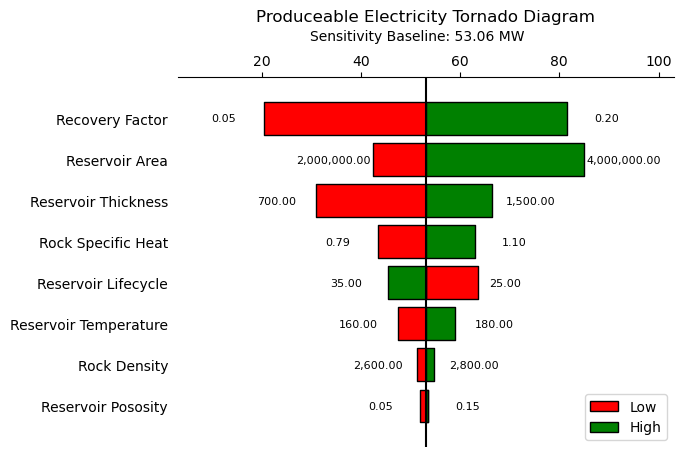

In [50]:
# Adapted from https://stackoverflow.com/questions/32132773/a-tornado-chart-and-p10-p90-in-python-matplotlib
variables = [stats['Parameter'][6], stats['Parameter'][0], stats['Parameter'][1], 
             stats['Parameter'][8], stats['Parameter'][7], stats['Parameter'][4],
             stats['Parameter'][2], stats['Parameter'][3]]

base = P_e_base

# low values
lin = np.array([Rg_a, area_a, thickness_a, c_r_a, t_i_a, T_i_a, rho_r_a, phi_a])
lows = np.array([P_e_RgLow, P_e_areaLow, P_e_thicknessLow, P_e_c_rLow, P_e_t_iLow, P_e_T_iLow, 
                 P_e_rho_rLow, P_e_phiLow])
# switch P_e_T_iHigh for P_e_T_iLow due to inverse relationship with output to display in the diagram
los = np.array([Rg_a, area_a, thickness_a, c_r_a, t_i_c, T_i_a, rho_r_a, phi_a]) 

# high values
hin = np.array([Rg_c, area_c, thickness_c, c_r_c, t_i_c, T_i_c,  rho_r_c, phi_c])
highs = np.array([P_e_RgHigh, P_e_areaHigh, P_e_thicknessHigh, P_e_c_rHigh, P_e_t_iHigh, P_e_T_iHigh,
                 P_e_rho_rHigh, P_e_phiHigh])
# switch P_e_T_iHigh for P_e_T_iLow due to inverse relationship with output to display in the diagram
higs = np.array([Rg_c, area_c, thickness_c, c_r_c, t_i_a, T_i_c,  rho_r_c, phi_c])

# swing
values = np.array([P_e_RgSwing, P_e_areaSwing, P_e_thicknessSwing, P_e_c_rSwing, P_e_t_iSwing, P_e_T_iSwing, P_e_rho_rSwing, 
                   P_e_phiSwing])

###############################################################################
# The actual drawing part

# The y position for each variable
ys = range(len(values))[::-1]  # top to bottom

fig, ax = plt.subplots()

# Plot the bars, one by one
for i, (y, low, value, high, hi, li, hig, lo) in enumerate(zip(ys, lows, values, highs, hin, lin, higs, los)):
    # The width of the 'low' and 'high' pieces
    low_width = base - low
    high_width = low + value - base

    # Each bar is a "broken" horizontal bar chart
    l=plt.broken_barh(
        [(low, low_width), (base, high_width)],
        (y - 0.4, 0.8),
        facecolors=['red', 'green'],  # Try different colors if you like
        edgecolors=['black', 'black'],
        linewidth=1)

    # Display the value as text. It should be positioned in the center of
    # bar, except if there isn't any room there, then it should be next to bar instead.
    xh = high + 8
    if xh <= base + 8:
        xh = base + 16
    plt.text(xh, y, '{:4,.2f}'.format(hig), va='center', ha='center', fontsize = 8)
    
    xl = low - 8
    if xl >= base - 8:
        xl = base - 16
    plt.text(xl, y, '{:4,.2f}'.format(lo), va='center', ha='center', fontsize = 8)

# Draw a vertical line down the middle
plt.axvline(base, color='black')

# Position the x-axis on the top, hide all the other spines (=axis lines)
axes = plt.gca()  # (gca = get current axes)
axes.spines['left'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.xaxis.set_ticks_position('top')

# Title
plt.title('Produceable Electricity Tornado Diagram', y=1.13)
plt.suptitle('Sensitivity Baseline: {:4,.2f} MW'.format(P_e_base), fontsize = 10)

# Legend
h=ax.broken_barh([(base, high_width)], (y - 0.4, 0.8), 
                 facecolors=['green'],  # Try different colors if you like
                 edgecolors=['black', 'black'], linewidth=1)
ax.legend([l,h], ["Low", "High"], loc="lower right")

# Make the y-axis display the variables
plt.yticks(ys, variables)
axes.yaxis.set_ticks_position('none') 

# Set the portion of the x- and y-axes to show
plt.xlim(base - 50, base + 50)
plt.ylim(-1, len(variables));